# MNIST Flow Matching - Minimal Tutorial

A short, practical notebook to learn a flow-matching model on MNIST and visualize sampling trajectories.

## Outline
1. Setup and Data
2. Model (Velocity Field)
3. Training (Flow Matching Loss)
4. Sampling and Visualization


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reproducibility
torch.manual_seed(2025)
np.random.seed(2025)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Plot style
plt.style.use('seaborn-v0_8')

Using device: cpu


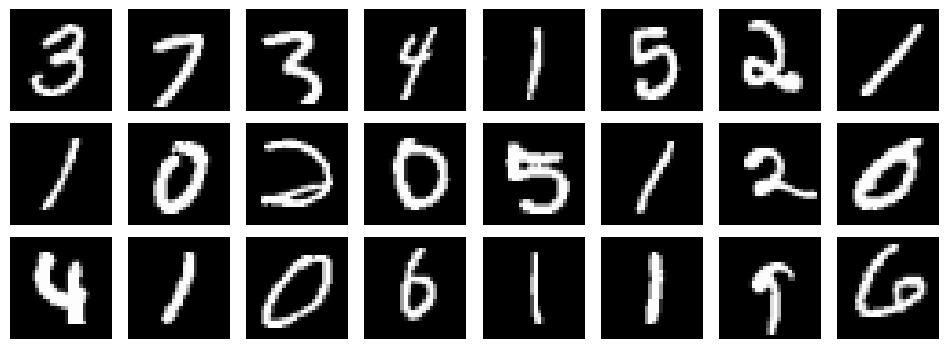

In [2]:
# 1) Setup and Data
img_size = 28
batch_size = 512

transform = transforms.Compose([
    transforms.ToTensor(),              # [0,1]
    transforms.Normalize((0.5,), (0.5,)) # to [-1,1]
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

# quick visualize
num_rows = 3
num_columns = 8
def show_batch(images, n=num_rows*num_columns):
    images = images[:n].cpu().numpy()
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns*1.2, num_rows*1.2))
    axes = axes.flatten()
    for i in range(n):
        axes[i].imshow(images[i,0], cmap='gray', vmin=-1, vmax=1)
        axes[i].axis('off')
    plt.tight_layout(); plt.show()

batch = next(iter(train_loader))[0]
show_batch(batch)

In [12]:
# 2) Model (velocity field v_theta(x_t, t))
class SinusoidalTime(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        # t in [0,1]
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(torch.arange(half, device=device).float() * (-np.log(10000.0)/half))
        angles = 2*np.pi * t * freqs
        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
        return emb

class VelocityUNetSmall(nn.Module):
    def __init__(self, img_size=28, channels=1, hidden=64, tdim=32):
        super().__init__()
        flat = img_size*img_size*channels
        self.tenc = SinusoidalTime(tdim)
        self.inp = nn.Linear(flat + tdim, hidden)
        self.mlp = nn.Sequential(
            nn.SiLU(), nn.Linear(hidden, hidden), nn.SiLU(), nn.Linear(hidden, flat)
        )
        self.img_size = img_size
        self.channels = channels
    def forward(self, x, t):
        b = x.size(0)
        x_flat = x.view(b, -1)
        temb = self.tenc(t)
        h = torch.cat([x_flat, temb], dim=-1)
        h = self.inp(h)
        v = self.mlp(h)
        return v.view(b, self.channels, self.img_size, self.img_size)

model = VelocityUNetSmall().to(device)
model = torch.compile(model)
print('Parameters:', sum(p.numel() for p in model.parameters())/1e6, 'M')

Parameters: 0.107408 M


***Sinusoidal time embedding***

1. **Frequency Generation**
For each frequency index $i \in \{0, 1, 2, \ldots, \frac{d}{2} - 1\}$:
$$f_i = \exp\left(i \cdot \frac{-\log(10000)}{\frac{d}{2}}\right)$$
where $d$ is the embedding dimension.
2. **Angle Computation**
For time $t \in [0, 1]$ and frequency $f_i$:
$$\theta_i = 2\pi \cdot t \cdot f_i$$
3. **Sinusoidal Encoding**
The final embedding vector $\mathbf{e}(t)$ has dimension $d$:
$$\mathbf{e}(t) = [\sin(\theta_0), \cos(\theta_0), \sin(\theta_1), \cos(\theta_1), \ldots, \sin(\theta_{\frac{d}{2}-1}), \cos(\theta_{\frac{d}{2}-1})]$$
4. **Complete Formula**
Combining all steps:
$$\mathbf{e}(t) = \begin{bmatrix}
\sin(2\pi \cdot t \cdot f_0) \\
\cos(2\pi \cdot t \cdot f_0) \\
\sin(2\pi \cdot t \cdot f_1) \\
\cos(2\pi \cdot t \cdot f_1) \\
\vdots \\
\sin(2\pi \cdot t \cdot f_{\frac{d}{2}-1}) \\
\cos(2\pi \cdot t \cdot f_{\frac{d}{2}-1})
\end{bmatrix}$$
where:
$f_i = \exp\left(i \cdot \frac{-\log(10000)}{\frac{d}{2}}\right)$
$t \in [0, 1]$ is the normalized time
$d$ is the embedding dimension (must be even)

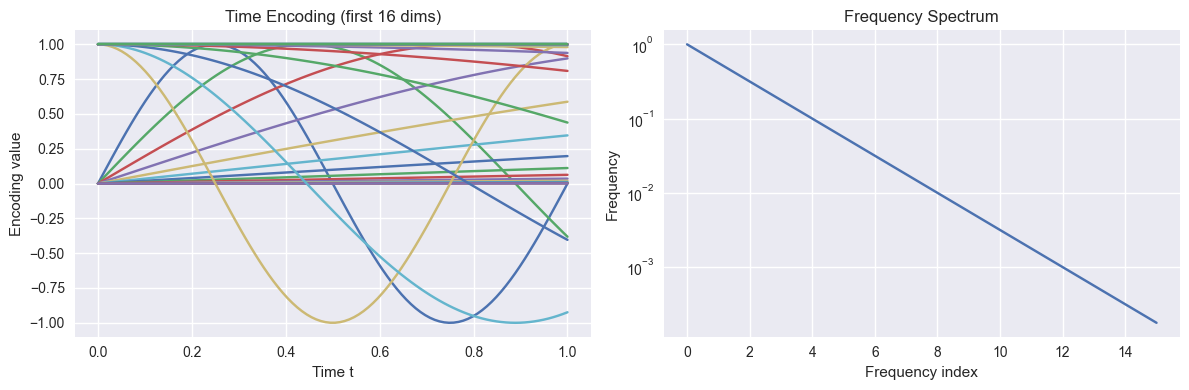

In [14]:
def visualize_time_encoding(t_values, dim=32):
    """Show how different times create different patterns"""
    encoding = SinusoidalTime(dim)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 1: Time vs Encoding (first 16 dimensions)
    times = torch.linspace(0, 1, 100)
    encodings = encoding(times.unsqueeze(-1))
    
    axes[0].plot(times.numpy(), encodings[:, :].numpy())
    axes[0].set_title('Time Encoding (first 16 dims)')
    axes[0].set_xlabel('Time t')
    axes[0].set_ylabel('Encoding value')
    
    # Plot 2: Frequency spectrum
    freqs = torch.exp(torch.arange(dim//2) * (-np.log(10000.0)/(dim//2)))
    axes[1].semilogy(freqs.numpy())
    axes[1].set_title('Frequency Spectrum')
    axes[1].set_xlabel('Frequency index')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_time_encoding(torch.linspace(0, 1, 100))

In [15]:
# 3) Training (Flow Matching)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=5e-5)
steps = 2000
log_every = 10

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
save_every = 50

loss_hist = []
model.train()
for step in tqdm(range(1, steps+1)):
    x1, _ = next(iter(train_loader))
    x1 = x1.to(device)
    x0 = torch.randn_like(x1)
    t = torch.rand(x1.size(0), 1, device=device)
    x_t = (1 - t.view(-1,1,1,1)) * x0 + t.view(-1,1,1,1) * x1
    v_true = x1 - x0
    v_pred = model(x_t, t)
    loss = F.mse_loss(v_pred, v_true)
    optimizer.zero_grad(); loss.backward(); optimizer.step()
    loss_hist.append(loss.item())
    if step % log_every == 0:
        print(f'Step {step}/{steps} - loss {loss.item():.4f}')

    # Auto-save
    if step % save_every == 0:
        checkpoint = {
            'step': step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'loss_history': loss_hist,
        }
        
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_step_{step}.pth')
        torch.save(checkpoint, checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')

plt.figure(figsize=(6,3))
plt.plot(loss_hist)
plt.title('Training Loss')
plt.xlabel('step'); plt.ylabel('MSE'); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

  1%| | 10/1000 [00:18<30:

Step 10/1000 - loss 1.7399


  2%| | 20/1000 [00:36<29:

Step 20/1000 - loss 1.4795


  3%| | 30/1000 [00:54<29:

Step 30/1000 - loss 1.3443


  4%| | 40/1000 [01:12<28:

Step 40/1000 - loss 1.2885


  5%| | 50/1000 [01:30<28:

Step 50/1000 - loss 1.2702
Checkpoint saved: ./checkpoints/checkpoint_step_50.pth


  6%| | 60/1000 [01:48<27:

Step 60/1000 - loss 1.2645


  7%| | 70/1000 [02:06<27:

Step 70/1000 - loss 1.2638


  8%| | 80/1000 [02:24<28:

Step 80/1000 - loss 1.2531


  9%| | 90/1000 [02:42<27:

Step 90/1000 - loss 1.2548


 10%| | 100/1000 [03:00<27

Step 100/1000 - loss 1.2420
Checkpoint saved: ./checkpoints/checkpoint_step_100.pth


 11%| | 110/1000 [03:18<26

Step 110/1000 - loss 1.2432


 12%| | 120/1000 [03:36<26

Step 120/1000 - loss 1.2377


 13%|▏| 130/1000 [03:55<26

Step 130/1000 - loss 1.2275


 14%|▏| 140/1000 [04:13<26

Step 140/1000 - loss 1.2235


 15%|▏| 150/1000 [04:31<25

Step 150/1000 - loss 1.2243
Checkpoint saved: ./checkpoints/checkpoint_step_150.pth


 16%|▏| 160/1000 [04:49<25

Step 160/1000 - loss 1.2231


 17%|▏| 170/1000 [05:07<24

Step 170/1000 - loss 1.2198


 18%|▏| 180/1000 [05:25<24

Step 180/1000 - loss 1.2159


 19%|▏| 190/1000 [05:43<24

Step 190/1000 - loss 1.2089


 20%|▏| 200/1000 [06:02<24

Step 200/1000 - loss 1.2075
Checkpoint saved: ./checkpoints/checkpoint_step_200.pth


 21%|▏| 210/1000 [06:20<23

Step 210/1000 - loss 1.2069


 22%|▏| 220/1000 [06:38<23

Step 220/1000 - loss 1.2126


 23%|▏| 230/1000 [06:56<23

Step 230/1000 - loss 1.2131


 24%|▏| 240/1000 [07:14<22

Step 240/1000 - loss 1.2021


 25%|▎| 250/1000 [07:32<22

Step 250/1000 - loss 1.2023
Checkpoint saved: ./checkpoints/checkpoint_step_250.pth


 26%|▎| 260/1000 [07:51<22

Step 260/1000 - loss 1.2037


 27%|▎| 270/1000 [08:09<22

Step 270/1000 - loss 1.2040


 28%|▎| 280/1000 [08:27<21

Step 280/1000 - loss 1.2039


 29%|▎| 290/1000 [08:45<21

Step 290/1000 - loss 1.1929


 30%|▎| 300/1000 [09:03<21

Step 300/1000 - loss 1.1973
Checkpoint saved: ./checkpoints/checkpoint_step_300.pth


 31%|▎| 310/1000 [09:21<20

Step 310/1000 - loss 1.1968


 32%|▎| 320/1000 [09:40<20

Step 320/1000 - loss 1.1984


 33%|▎| 330/1000 [09:58<20

Step 330/1000 - loss 1.1869


 34%|▎| 340/1000 [10:16<20

Step 340/1000 - loss 1.1919


 35%|▎| 350/1000 [10:34<19

Step 350/1000 - loss 1.1930
Checkpoint saved: ./checkpoints/checkpoint_step_350.pth


 36%|▎| 360/1000 [10:53<19

Step 360/1000 - loss 1.1908


 37%|▎| 370/1000 [11:11<19

Step 370/1000 - loss 1.1861


 38%|▍| 380/1000 [11:29<18

Step 380/1000 - loss 1.1857


 39%|▍| 390/1000 [11:47<18

Step 390/1000 - loss 1.1805


 40%|▍| 400/1000 [12:05<18

Step 400/1000 - loss 1.1831
Checkpoint saved: ./checkpoints/checkpoint_step_400.pth


 41%|▍| 410/1000 [12:23<17

Step 410/1000 - loss 1.1877


 42%|▍| 420/1000 [12:42<17

Step 420/1000 - loss 1.1853


 43%|▍| 430/1000 [13:00<16

Step 430/1000 - loss 1.1867


 44%|▍| 440/1000 [13:18<16

Step 440/1000 - loss 1.1818


 45%|▍| 450/1000 [13:36<16

Step 450/1000 - loss 1.1836
Checkpoint saved: ./checkpoints/checkpoint_step_450.pth


 46%|▍| 460/1000 [13:54<16

Step 460/1000 - loss 1.1776


 47%|▍| 470/1000 [14:12<16

Step 470/1000 - loss 1.1861


 48%|▍| 480/1000 [14:30<15

Step 480/1000 - loss 1.1778


 49%|▍| 490/1000 [14:49<15

Step 490/1000 - loss 1.1817


 50%|▌| 500/1000 [15:07<15

Step 500/1000 - loss 1.1788
Checkpoint saved: ./checkpoints/checkpoint_step_500.pth


 50%|▌| 505/1000 [15:16<14Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
 50%|▌| 505/1000 [15:16<14

Unexpected exception formatting exception. Falling back to standard exception



    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/guanyas/Desktop/Guanya_Research/flow/flow_tutorial/lib/python3.9/site-packages/torch/__init__.py", line 1837, in <module>
    self = reduction.pickle.load(from_parent)
  File "/Users/guanyas/Desktop/Guanya_Research/flow/flow_tutorial/lib/python3.9/site-packages/torch/__init__.py", line 1837, in <module>
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    exitcode = _main(fd, parent_sentinel)
  F

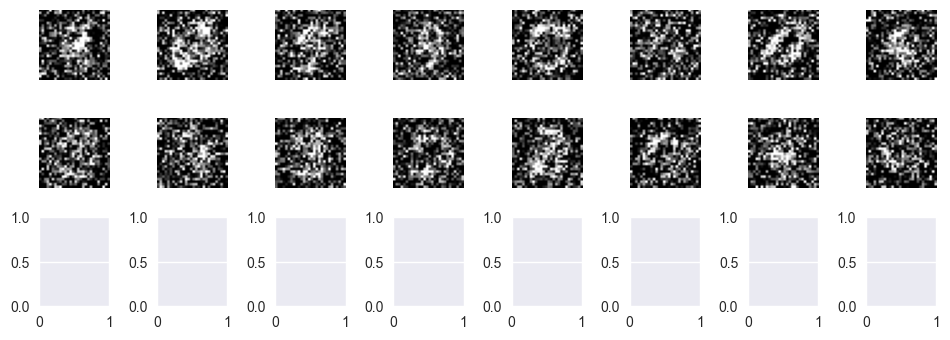

<Figure size 800x550 with 0 Axes>

In [24]:
# 4) Sampling and Visualization
@torch.no_grad()
def sample_flow(model, num=16, steps=100):
    model.eval()
    x = torch.randn(num, 1, img_size, img_size, device=device)
    dt = 1.0/steps
    grids = []
    for s in range(steps):
        t = torch.full((num,1), (s+1)*dt, device=device)
        v = model(x, t)
        x = x + v*dt
        if (s+1) % (steps//4) == 0:
            grids.append(x.clamp(-1,1).cpu())
    return x.clamp(-1,1).cpu(), grids

checkpoint = torch.load('./checkpoints/checkpoint_step_500.pth', map_location=device)    
model.load_state_dict(checkpoint['model_state_dict'])
samples, grids = sample_flow(model, num=16, steps=100)

# show final samples
show_batch(samples, n=16)

# show flow "trajectories" (quarter checkpoints)
fig, axes = plt.subplots(len(grids), 16, figsize=(16, 4*len(grids)))
for r, g in enumerate(grids):
    gnp = g.numpy()
    for c in range(16):
        axes[r, c].imshow(gnp[c,0], cmap='gray', vmin=-1, vmax=1)
        axes[r, c].axis('off')

plt.tight_layout(); plt.show()